# Generate simulated data

Generate simulated data by sampling from VAE latent sapce

Workflow:
1. Input gene expression data from 1 experiment (here we are assuming that there is only biological variation within this experiment)
2. Encode this input into a latent space using the trained VAE model
3. For each encoded feature, sample from a distribution using the the mean and standard deviation for that feature
4. Decode the samples

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import pickle
from keras.models import model_from_json, load_model
from ggplot import *
import umap
import warnings
warnings.filterwarnings(action='once')

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [2]:
# Parameters
analysis_name = 'experiment_1'
NN_architecture = 'NN_2500_20'
metadata_field = 'strain'
num_simulated_samples = 1000

In [3]:
# Create directories
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

new_dir = os.path.join(base_dir, "data", "simulated")

analysis_dir = os.path.join(new_dir, analysis_name)

if os.path.exists(analysis_dir):
    print('directory already exists: {}'.format(analysis_dir))
else:
    print('creating new directory: {}'.format(analysis_dir))
os.makedirs(analysis_dir, exist_ok=True)

directory already exists: /home/alexandra/Documents/Repos/Batch_effects_simulation/data/simulated/experiment_1


In [4]:
# Load arguments
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

mapping_file = os.path.join(
    base_dir,
    "data",
    "metadata",
    "mapping_{}.txt".format(metadata_field))

normalized_data_file = os.path.join(
    base_dir,
    "data",
    "input",
    "train_set_normalized.pcl")

encoded_data_file = glob.glob(os.path.join(
    base_dir,
    "data",
    "encoded",
    NN_architecture,
    "*encoded.txt"))[0]

model_encoder_file = glob.glob(os.path.join(
    base_dir,
    "models",
    NN_architecture,
    "*_encoder_model.h5"))[0]

weights_encoder_file = glob.glob(os.path.join(
    base_dir,
    "models",
    NN_architecture,
    "*_encoder_weights.h5"))[0]

model_decoder_file = glob.glob(os.path.join(
    base_dir,
    "models", 
    NN_architecture,
    "*_decoder_model.h5"))[0]


weights_decoder_file = glob.glob(os.path.join(
    base_dir,
    "models",  
    NN_architecture,
    "*_decoder_weights.h5"))[0]

# Output
simulated_data_file = os.path.join(
    base_dir,
    "data",
    "simulated",
    analysis_name,
    "simulated_data.txt")

simulated_data_mapping_file = os.path.join(
    base_dir,
    "data",
    "metadata",
    "mapping_simulated_data.txt")

umap_model_file = os.path.join(
    base_dir,
    "models",  
    NN_architecture,
    "umap_model.pkl")

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# Read in VAE models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

In [5]:
# Read in UMAP model
infile = open(umap_model_file, 'rb')
model = pickle.load(infile)
infile.close()

In [6]:
# Read data
normalized_data = pd.read_table(
    normalized_data_file,
    header=0,
    sep='\t',
    index_col=0).T

print(normalized_data.shape)
normalized_data.head(10)

(950, 5549)


Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814
control1aerobic_Pae_G1a.CEL,0.365512,0.572967,0.417762,0.663096,0.424846,0.606590,0.378900,0.224257,0.161582,0.074461,...,0.491161,0.565151,0.595824,0.382989,0.352268,0.250905,0.362161,0.487777,0.729434,0.483384
control1_anaerobic_Pae_G1a.CEL,0.689254,0.723461,0.510094,0.801569,0.619374,0.937262,0.138600,0.298615,0.306533,0.032482,...,0.754845,0.711126,0.589279,0.542699,0.591066,0.421389,0.392671,0.686055,0.911163,0.585208
control2aerobic_Pae_G1a.CEL,0.353000,0.580626,0.302544,0.639624,0.281793,0.687343,0.462645,0.000000,0.107961,0.093163,...,0.466139,0.545104,0.487957,0.330583,0.419139,0.328478,0.298493,0.254059,0.588305,0.406311
control2_anaerobic_Pae_G1a.CEL,0.674305,0.680740,0.515478,0.747121,0.656701,0.910654,0.149744,0.262492,0.263528,0.019910,...,0.775338,0.653142,0.642205,0.550935,0.565532,0.458622,0.426767,0.701314,0.886074,0.556363
control3aerobic_Pae_G1a.CEL,0.399186,0.653977,0.328755,0.692895,0.482482,0.618446,0.308135,0.191401,0.201170,0.020375,...,0.560889,0.654797,0.493961,0.454766,0.464733,0.456465,0.348577,0.503229,0.718768,0.474649


In [7]:
# Read encoded data
encoded_data = pd.read_table(
    encoded_data_file,
    header=0,
    sep='\t',
    index_col=0)

print(encoded_data.shape)
encoded_data.head(10)

(950, 20)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
05_PA14000-4-2_5-10-07_S2.CEL,0.000000,0.000000,2.881807,4.025048,0.026121,0.000000,0.233073,0.000000,0.285552,0.000000,3.521488,2.349849,0.000000,0.221006,0.040035,0.119289,0.000000,2.267663,3.790878,0.622564
54375-4-05.CEL,0.271458,0.279838,5.314808,0.014325,0.023810,0.171173,0.294140,0.293523,0.000000,0.000000,0.000000,4.662211,0.000000,0.000000,0.221577,0.027970,1.871457,0.460128,0.651031,1.523954
AKGlu_plus_nt_7-8-09_s1.CEL,0.884178,0.000000,0.874608,5.964780,1.225151,0.000000,1.450733,0.000000,0.000000,0.544627,1.458417,1.502698,0.000000,0.311754,0.000000,0.169599,0.000000,3.467533,2.929476,0.000000
anaerobic_NO3_1.CEL,0.000000,7.119679,0.000000,6.034766,1.123290,1.156022,0.000000,0.000000,0.000000,0.572917,0.000000,0.000000,0.905534,0.226940,0.000000,0.498183,1.583261,0.000000,0.000000,0.000000
anaerobic_NO3_2.CEL,0.000000,7.092632,0.000000,6.480810,0.998179,0.939759,0.000000,0.000000,0.000000,0.597160,0.000000,0.000000,0.911045,0.139518,0.000000,0.508703,1.863557,0.000000,0.000000,0.000000
control1aerobic_Pae_G1a.CEL,0.000000,0.283649,0.000000,0.520822,4.961012,0.000000,0.000000,4.970084,1.993324,0.000000,0.679801,0.000000,3.124849,0.000000,0.100840,0.000000,0.161994,0.000000,0.000000,0.010050
control1_anaerobic_Pae_G1a.CEL,0.000000,0.000000,0.000000,0.171366,4.795333,0.000000,0.000000,5.076245,1.661616,0.000000,3.410705,0.000000,2.294760,0.000000,0.000000,0.000000,0.000000,0.000000,0.150745,2.953038
control2aerobic_Pae_G1a.CEL,0.000000,1.545221,0.000000,0.115196,5.243724,0.000000,0.000000,4.077643,2.369878,0.000000,0.000000,0.000000,3.325455,0.000000,0.550063,0.000000,0.410258,0.000000,0.000000,0.000000
control2_anaerobic_Pae_G1a.CEL,0.000000,0.000000,0.000000,0.091387,4.557496,0.000000,0.000000,5.016538,1.812587,0.000000,3.579182,0.000000,2.381885,0.000000,0.000000,0.000000,0.000000,0.158537,0.093915,2.600331
control3aerobic_Pae_G1a.CEL,0.000000,0.214737,0.000000,0.606456,5.336023,0.000000,0.000000,5.027914,1.547833,0.000000,0.815024,0.000000,3.292789,0.000000,0.000000,0.000000,0.343207,0.000000,0.000000,0.057345


In [8]:
# Read in metadata
metadata = pd.read_table(
    mapping_file, 
    header=0, 
    sep='\t', 
    index_col=0)

metadata.head(10)

,strain
ml_data_source,
GSM1141730_PA01_ZnO_PZO_.CEL,PAO1
GSM1141729_PA01_none_PC_.CEL,PAO1
GSM1608059_Planktonic_1.CEL,PAO1
GSM1608060_Planktonic_2.CEL,PAO1
GSM1608061_Planktonic_3.CEL,PAO1
GSM1608062_Planktonic_4.CEL,PAO1
GSM1608067_Biofilm+12hrcipro_rep1.CEL,PAO1
GSM1608068_Biofilm+12hrcipro_rep2.CEL,PAO1
GSM1608069_Biofilm+12hrcipro_rep3.CEL,PAO1


In [9]:
# Replace NaN with string "NA"
metadata[metadata_field] = metadata[metadata_field].fillna('NA')

In [10]:
# Get possible values in metadata field
grps = list(metadata[metadata_field].unique())
print(grps)

['PAO1', 'PA14', 'NA', 'CF sputum isolate']


## Simulate data

Generate new simulated data by sampling from the distribution of latent space features.  In other words, for each latent space feature get the mean and standard deviation.  Then we can generate a new sample by sampling from a distribution with this mean and standard deviation.

In [11]:
# Encode into latent space
data_encoded = loaded_model.predict_on_batch(normalized_data)
data_encoded_df = pd.DataFrame(data_encoded, index=normalized_data.index)

In [12]:
# Merge encoded gene expression data and metadata
data_encoded_labeled = encoded_data.merge(
    metadata,
    left_index=True, 
    right_index=True, 
    how='inner')

print(data_encoded_labeled.shape)
data_encoded_labeled.head(5)

(989, 21)


,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,strain
05_PA14000-4-2_5-10-07_S2.CEL,0.000000,0.000000,2.881807,4.025048,0.026121,0.000000,0.233073,0.000000,0.285552,0.000000,...,2.349849,0.000000,0.221006,0.040035,0.119289,0.000000,2.267663,3.790878,0.622564,PA14
54375-4-05.CEL,0.271458,0.279838,5.314808,0.014325,0.023810,0.171173,0.294140,0.293523,0.000000,0.000000,...,4.662211,0.000000,0.000000,0.221577,0.027970,1.871457,0.460128,0.651031,1.523954,PAO1
AKGlu_plus_nt_7-8-09_s1.CEL,0.884178,0.000000,0.874608,5.964780,1.225151,0.000000,1.450733,0.000000,0.000000,0.544627,...,1.502698,0.000000,0.311754,0.000000,0.169599,0.000000,3.467533,2.929476,0.000000,PA14
DB1.CEL,1.141864,0.190562,0.564505,0.000000,0.404298,0.152109,0.452906,0.000000,0.000000,0.524291,...,0.000000,0.048547,0.185864,4.968468,0.000000,0.300306,0.000000,0.000000,0.000000,PAO1
DB3.CEL,0.882203,1.506860,0.336201,0.000000,0.820061,0.103091,1.109043,0.000000,0.000000,0.987604,...,0.000000,0.176782,0.000000,4.485586,0.131439,0.000000,0.000000,0.000000,0.064667,PAO1


In [13]:
# Init variables
num_samples_per_grp = int(num_simulated_samples/len(grps))
latent_dim = data_encoded_df.shape[1]
new_data = pd.DataFrame(columns=normalized_data.columns)
new_data_encoded = pd.DataFrame(columns=encoded_data.columns)

# Get mean and standard deviation for each group per encoded feature
for g in range(len(grps)):
    grp_name = grps[g]
    data_labeled_grped = data_encoded_labeled[data_encoded_labeled[metadata_field]== grps[g]]
    
    print('simulating data for {}...'.format(grp_name))
    
    # Calculate mean and stdev
    encoded_means = data_labeled_grped.mean(axis=0)
    encoded_stds = data_labeled_grped.std(axis=0)

    # Generate samples 
    new_data_tmp = np.zeros([num_samples_per_grp,latent_dim])
    for j in range(latent_dim):
        
        # Use mean and std for feature
        new_data_tmp[:,j] = np.random.normal(encoded_means[j], encoded_stds[j], num_samples_per_grp) 
        
        # Use standard normal
        #new_data[:,j] = np.random.normal(0, 1, num_simulated_samples)
        
    new_data_tmp_df = pd.DataFrame(data=new_data_tmp, columns=encoded_data.columns)
    new_data_encoded = new_data_encoded.append(new_data_tmp_df, ignore_index=True)
    

    # Decode N samples
    new_data_decoded = loaded_decode_model.predict_on_batch(new_data_tmp_df)
    new_data_decoded_df = pd.DataFrame(data=new_data_decoded, columns=normalized_data.columns)
    
    new_data = new_data.append(new_data_decoded_df, ignore_index=True)

print(new_data.shape)
new_data.head(10)

simulating data for PAO1...
simulating data for PA14...
simulating data for NA...
simulating data for CF sputum isolate...
(1000, 5549)


Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0,0.446957,0.643730,0.354168,0.581424,0.276973,0.303365,0.374227,0.460525,0.405243,0.180418,...,0.235136,0.524545,0.495369,0.411390,0.491835,0.293282,0.480864,0.436720,0.612998,0.492759
1,0.669778,0.644412,0.498653,0.610226,0.418455,0.443748,0.353707,0.550629,0.480056,0.200336,...,0.418858,0.586383,0.560669,0.533606,0.537233,0.255870,0.508560,0.578685,0.655122,0.641101
2,0.657138,0.730673,0.440241,0.702760,0.385269,0.373569,0.362133,0.483341,0.433026,0.161613,...,0.310219,0.546557,0.495103,0.451879,0.448654,0.215856,0.438995,0.432516,0.615505,0.548398
3,0.723734,0.667772,0.469858,0.684377,0.416712,0.502864,0.334403,0.576391,0.575824,0.185063,...,0.472288,0.635912,0.578134,0.661214,0.677254,0.272760,0.551928,0.716744,0.704614,0.743591
4,0.604745,0.631769,0.417092,0.606435,0.365324,0.366674,0.457452,0.484630,0.444616,0.186451,...,0.406186,0.518205,0.548476,0.535507,0.577210,0.214304,0.447972,0.475188,0.660519,0.617953
5,0.393833,0.441538,0.462849,0.413818,0.252220,0.329054,0.420920,0.414463,0.289230,0.257735,...,0.505044,0.532643,0.534202,0.388367,0.426247,0.321606,0.593929,0.454505,0.530716,0.486531
6,0.646332,0.666576,0.520155,0.660582,0.327622,0.420341,0.507159,0.520566,0.466660,0.173926,...,0.310077,0.514585,0.572118,0.409392,0.408634,0.152498,0.410186,0.357153,0.561198,0.523708
7,0.545069,0.538265,0.405931,0.492182,0.366361,0.400498,0.338944,0.489148,0.456469,0.214793,...,0.385395,0.512551,0.504046,0.507975,0.559667,0.334660,0.528677,0.524593,0.615336,0.620235
8,0.756644,0.690710,0.518062,0.669596,0.451826,0.367823,0.252145,0.686577,0.748654,0.196950,...,0.420365,0.612563,0.656352,0.619437,0.708211,0.184388,0.516549,0.667663,0.739598,0.741968
9,0.616562,0.644032,0.408858,0.621177,0.302901,0.304532,0.457121,0.511133,0.408189,0.180751,...,0.316074,0.527674,0.509688,0.428431,0.469661,0.217287,0.419857,0.415159,0.570727,0.569257


In [14]:
# Create labels for new data
grps_series = pd.Series(grps)
new_metadata = pd.DataFrame(grps_series.repeat(num_samples_per_grp), columns=['metadata'])
new_metadata.index = new_data.index

In [15]:
# Merge gene expression data and metadata
new_data_labeled = new_data.merge(
    new_metadata,
    left_index=True, 
    right_index=True, 
    how='inner')

print(new_data_labeled.shape)
new_data_labeled.head(5)

(1000, 5550)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,metadata
0,0.446957,0.643730,0.354168,0.581424,0.276973,0.303365,0.374227,0.460525,0.405243,0.180418,...,0.524545,0.495369,0.411390,0.491835,0.293282,0.480864,0.436720,0.612998,0.492759,PAO1
1,0.669778,0.644412,0.498653,0.610226,0.418455,0.443748,0.353707,0.550629,0.480056,0.200336,...,0.586383,0.560669,0.533606,0.537233,0.255870,0.508560,0.578685,0.655122,0.641101,PAO1
2,0.657138,0.730673,0.440241,0.702760,0.385269,0.373569,0.362133,0.483341,0.433026,0.161613,...,0.546557,0.495103,0.451879,0.448654,0.215856,0.438995,0.432516,0.615505,0.548398,PAO1
3,0.723734,0.667772,0.469858,0.684377,0.416712,0.502864,0.334403,0.576391,0.575824,0.185063,...,0.635912,0.578134,0.661214,0.677254,0.272760,0.551928,0.716744,0.704614,0.743591,PAO1
4,0.604745,0.631769,0.417092,0.606435,0.365324,0.366674,0.457452,0.484630,0.444616,0.186451,...,0.518205,0.548476,0.535507,0.577210,0.214304,0.447972,0.475188,0.660519,0.617953,PAO1


## Plot simulated input data using UMAP

Note: we will use the same UMAP mapping for the input and simulated data to ensure they are plotted on the same space.

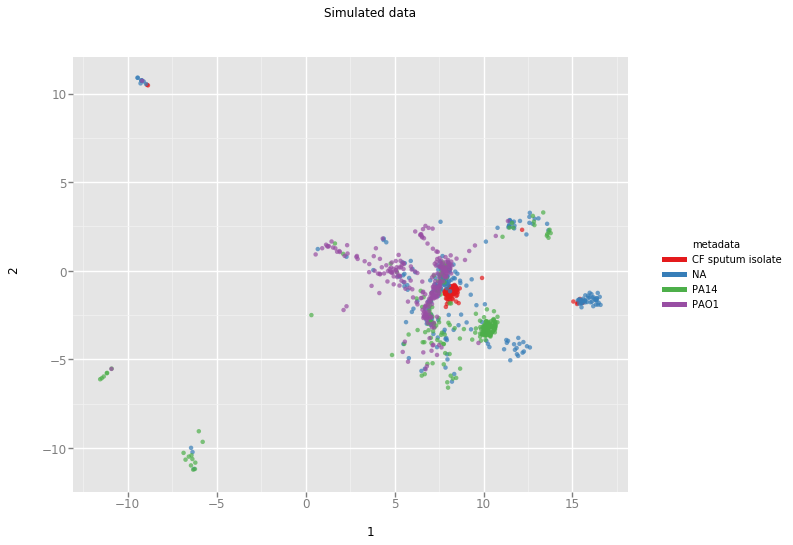

<ggplot: (8749698699840)>


In [16]:
# UMAP embedding
simulated_data_UMAP = model.transform(new_data_labeled.iloc[:,:-1])
simulated_data_UMAP_df = pd.DataFrame(data=simulated_data_UMAP,
                                         index=new_data_labeled.index,
                                         columns=['1','2'])
simulated_data_UMAP_df['metadata'] = list(new_data_labeled['metadata'])

g = ggplot(aes(x='1',y='2', color='metadata'), data=simulated_data_UMAP_df) + \
            geom_point(alpha=0.7) + \
            scale_color_brewer(type='qual', palette='Set1') + \
            ggtitle("Simulated data")

print(g)

In [17]:
# Output
new_data.to_csv(simulated_data_file, sep='\t')
new_metadata.to_csv(simulated_data_mapping_file, sep='\t')